In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from signed_distance import *
from nlp_builder import NLPBuilder
from nlp_solver import SQPSolver
from functools import partial

from pathlib import Path
from pybullet_suite import *
from panda_collision import *

import open3d as o3d
from open3d.utility import Vector3dVector as Vector
from open3d.visualization import draw_geometries as draw

pybullet build time: May 20 2022 19:44:17


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# problem
obs_center = jnp.array([0.6, 0, 0.6])
obs_r = 0.2

safe_dist = 0.1
dim_robot = 7
num_steps = 8

In [3]:
robot_path = Path(PANDA_URDF).parent / "meshes/collision"
mesh_names = [
    'link0', 'link1', 'link2', 'link3', 'link4', 
    'link5', 'link6', 'link7', 'hand', "finger", "finger"
]
fk = get_fk_fn(PANDA_URDF)
robotpc = get_pointclouds(robot_path, mesh_names, 10)

Robot name: panda


only got 9/10 samples!
only got 7/10 samples!


In [4]:
# points = robotpc.apply_transforms(fk(jnp.zeros(7)))
# pc = o3d.gdeometry.PointCloud(Vector(points))
# draw([pc])

In [6]:
bw = BulletWorld(gui=True)
sm = BulletSceneMaker(bw)
pandas = [bw.load_robot(Panda, f"panda{i}") for i in range(8)]

error: Only one local in-process GUI/GUI_SERVER connection allowed. Use DIRECT connection mode or start a separate GUI physics server (ExampleBrowser, App_SharedMemoryPhysics_GUI, App_SharedMemoryPhysics_VR) and connect over SHARED_MEMORY, UDP or TCP instead.

In [7]:
obs_bullet = sm.create_sphere("obstacle", obs_r, 0.1, Pose.identity(), [1,0,0,0.3])
obs_bullet.set_base_pose(Pose(trans=np.asarray(obs_center)))

In [8]:
#util functions
def to_mat(x):
    return x.reshape(-1, dim_robot)
def to_vec(mat):
    return mat.flatten()
def at_timestep(i, x):
    return to_mat(x)[i]
def to_vel(x):
    return (to_mat(x)[1:] - to_mat(x)[:-1]).flatten()

#visualize
def show_path(x):
    qs = to_mat(x)
    for i, q in enumerate(qs):
        pandas[i].set_joint_angles(q)

In [10]:
# functions
obs = Circle(obs_center, obs_r)
env = EnvSDF((obs,), safe_dist)
assign_points = lambda q: robotpc.apply_transforms(fk(q))
assign_points_path = lambda x: jnp.vstack(jax.vmap(assign_points)(to_mat(x)))
    
state_init = partial(at_timestep, 0)
state_goal = partial(at_timestep,-1)
penetration = lambda x: env.penetrations(assign_points_path(x))

def min_dist_cost(x):
    v = to_vel(x)
    return v @ v + penetration(x)

get_ee_point = lambda q: fk(q)[-1, -3:]
get_ee_points = lambda x: jax.vmap(get_ee_point)(to_mat(x))

def min_ee_dist_cost(x):
    ee_pos_mat = get_ee_points(x)
    ee_vel_mat = ee_pos_mat[1:] - ee_pos_mat[:-1]
    ee_vel = ee_vel_mat.flatten()
    return ee_vel @ ee_vel

panda = pandas[0]
ql = jnp.array(panda.joint_lower_limit)
qu = jnp.array(panda.joint_upper_limit)
q_init = jnp.array([-0.9   ,  0.    ,  0.    , -1.7708,  0.    ,  1.8675,  0.    ])
q_goal  = jnp.array([0.9   ,  0.    ,  0.    , -1.7708,  0.    ,  1.8675,  0.    ])
xl = jnp.tile(ql, num_steps)
xu = jnp.tile(qu, num_steps)
x0 = jnp.linspace(q_init, q_goal, 8).flatten()
show_path(x0)

In [11]:
#build NLP problem 
dim = num_steps * dim_robot
nlp = NLPBuilder(dim=dim)
nlp.set_f(min_dist_cost)
nlp.add_eq_const(state_init, q_init)
nlp.add_eq_const(state_goal, q_goal)
nlp.add_eq_const(penetration, 0.)
nlp.set_state_bound(xl, xu)

In [61]:
def state_bound_fn(x):
    return jnp.hstack([-x + jnp.ones_like(x), x - jnp.ones_like(x)])
xrand = jnp.array(np.random.random(dim))
jac_sparsity = []
_ = jax.jacfwd(state_init)(xrand) != 0.
jac_sparsity.append(_)
_ = jax.jacfwd(state_goal)(xrand) != 0.
jac_sparsity.append(_)

In [65]:
jax.jacfwd(state_bound_fn)(x0)

Array([[-1., -0., -0., ..., -0., -0., -0.],
       [-0., -1., -0., ..., -0., -0., -0.],
       [-0., -0., -1., ..., -0., -0., -0.],
       ...,
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.]], dtype=float32)

In [60]:
jnp.nonzero(jnp.vstack(jac_sparsity))

(Array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13], dtype=int32),
 Array([ 0,  1,  2,  3,  4,  5,  6, 49, 50, 51, 52, 53, 54, 55], dtype=int32))

In [12]:
solver = SQPSolver.from_builder(nlp)
solver.prebuild(mode="BFGS")

In [11]:
# debug
# from cvxopt import matrix, sparse
# state = solver.eval_fn(x0, jnp.zeros(nlp.const_dim), 0.1)
# P, q, G, h, A, b = solver.convexify(state)

In [51]:
jnp.nonzero(jax.jacrev(state_goal)(x0))

(Array([0, 1, 2, 3, 4, 5, 6], dtype=int32),
 Array([49, 50, 51, 52, 53, 54, 55], dtype=int32))

In [25]:
#x_rand = np.random.random(len())
h_jac_row, h_jac_col = jnp.nonzero(jax.jacrev(solver.h_fn)(x0))

In [44]:
jnp.nonzero(jax.hessian(solver.f_fn)(x0))

(Array([ 0,  0,  1,  1,  2,  2,  3,  3,  4,  4,  5,  5,  6,  6,  7,  7,  7,
         8,  8,  8,  9,  9,  9, 10, 10, 10, 11, 11, 11, 12, 12, 12, 13, 13,
        13, 14, 14, 14, 15, 15, 15, 16, 16, 16, 17, 17, 17, 18, 18, 18, 19,
        19, 19, 20, 20, 20, 21, 21, 21, 22, 22, 22, 23, 23, 23, 24, 24, 24,
        25, 25, 25, 26, 26, 26, 27, 27, 27, 28, 28, 28, 29, 29, 29, 30, 30,
        30, 31, 31, 31, 32, 32, 32, 33, 33, 33, 34, 34, 34, 35, 35, 35, 36,
        36, 36, 37, 37, 37, 38, 38, 38, 39, 39, 39, 40, 40, 40, 41, 41, 41,
        42, 42, 42, 43, 43, 43, 44, 44, 44, 45, 45, 45, 46, 46, 46, 47, 47,
        47, 48, 48, 48, 49, 49, 50, 50, 51, 51, 52, 52, 53, 53, 54, 54, 55,
        55], dtype=int32),
 Array([ 0,  7,  1,  8,  2,  9,  3, 10,  4, 11,  5, 12,  6, 13,  0,  7, 14,
         1,  8, 15,  2,  9, 16,  3, 10, 17,  4, 11, 18,  5, 12, 19,  6, 13,
        20,  7, 14, 21,  8, 15, 22,  9, 16, 23, 10, 17, 24, 11, 18, 25, 12,
        19, 26, 13, 20, 27, 14, 21, 28, 15, 22, 29, 16, 23, 3

In [26]:
h_jac = lambda x: jax.jacrev(solver.h_fn)(x)[h_jac_row, h_jac_col]

In [28]:
h_jac = jax.jit(h_jac)

In [35]:
%timeit jax.jit(jax.jacrev(solver.h_fn))(x0)

24.7 ms ± 303 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [32]:
%timeit h_jac(x0)

18 µs ± 653 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [13]:
xsol = solver.solve(x0, tol=0.05, verbose=True, save_history=True)

Exception ignored in: <function BulletClient.__del__ at 0x7f4b94605040>
Traceback (most recent call last):
  File "/home/polde/miniconda3/envs/cu11/lib/python3.8/site-packages/pybullet_utils/bullet_client.py", line 39, in __del__
    if self._client>=0 and self._pid == os.getpid():
  File "/home/polde/miniconda3/envs/cu11/lib/python3.8/site-packages/pybullet_utils/bullet_client.py", line 48, in __getattr__
    attribute = getattr(pybullet, name)
AttributeError: module 'pybullet' has no attribute '_client'


KeyboardInterrupt: 

In [13]:
xs = [h.x for h in solver.states]
ds = [jnp.linalg.norm(h.direction) for h in solver.history]
#ms = [h.m for h in solver.history]

In [1]:
ds[-10:]

NameError: name 'ds' is not defined

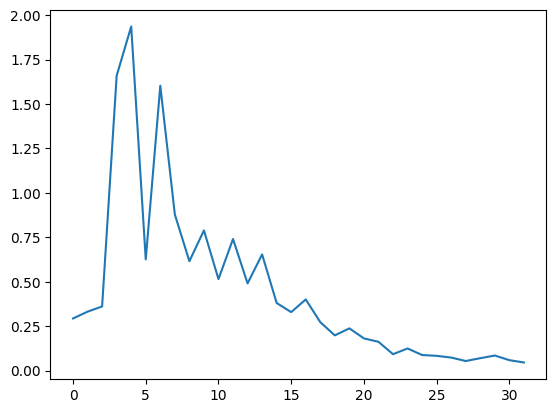

In [13]:
# with min ee dist cost
plt.plot(ds)

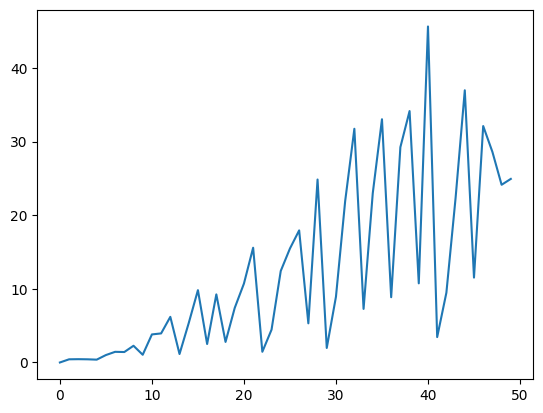

In [57]:
# with min dist cost
plt.plot(jnp.array(ms).max(axis=1))

In [123]:
jnp.array(lag_grads).argmax(axis=1)

Array([49, 37, 28, 22, 29, 29, 28, 28, 28, 22, 28, 28, 22, 22, 28, 28, 31,
       31, 28, 28, 31, 31, 28, 28, 15, 15, 28, 28, 15, 15, 28, 28, 15, 15,
       28, 28, 15, 15, 28, 28, 28, 28, 28, 28, 28, 24], dtype=int32)

In [148]:
scale = jnp.array(lag_grads).max(axis=0) - jnp.array(lag_grads).min(axis=0)

In [153]:
scaled_grad = jnp.array(lag_grads) / scale

In [155]:
jnp.linalg.norm(scaled_grad, jnp.inf, axis=1)

Array([0.99999857, 0.99992883, 0.98198867, 0.6564444 , 0.7880862 ,
       0.7776745 , 0.9863725 , 0.97753435, 0.7184059 , 0.42343292,
       0.61636525, 0.5824696 , 0.82872003, 0.8192711 , 0.77263904,
       0.7551455 , 0.93261147, 0.7472565 , 0.46235412, 0.45704332,
       1.        , 0.98877543, 0.73230845, 0.7235934 , 0.8485741 ,
       0.8390106 , 0.7468877 , 0.737932  , 0.87231165, 0.8597755 ,
       0.7632451 , 0.7517424 , 0.8728272 , 0.855628  , 0.75550294,
       0.7487601 , 0.8685142 , 0.8168072 , 0.4936103 , 0.49458748,
       0.76457816, 0.6854551 , 0.5587554 , 0.43950135, 0.9901103 ,
       0.97432834], dtype=float32)

In [14]:
i = 0

In [52]:
show_path(xs[i])
print(f"{i+1}/{len(xs)}")
i+=1

IndexError: list index out of range

: 

In [32]:
qs = to_mat(xs[-1])

In [33]:
show_path(jnp.zeros_like(qs))

In [34]:
i = 0

In [42]:
pandas[0].set_joint_angles(qs[i])
i += 1